# Infer ***nuclei*** - 1️⃣ 

--------------

## OVERVIEW
We will start by segmenting the different cell regions - the nucleus, cell, and cytoplasm - since they will be necessary for determining which organelle are in which cell. This is integral to our single cell analysis approach.

This notebook goes through the workflow steps to segment the ***nucleus*** from a fluorescent nuclei marker.


## OBJECTIVE: 
### ✅ Infer sub-cellular component #1: ***nuclei***
Segment the ***nuclei*** from a single channel (nuclei marker). This will be necessary to determine the other subcellular compartment - like the ***cytoplasm***. Nuclei will also be used to seed the instance segmentation of the ***cell*** area.

> ***Convention:***  "nuclei" for the segmentation of ALL nuclei in the image.  "nucleus" for the ***single*** nucleus associated to the single cell being analyzed (determined in [02_infer_cellmask_from-composite](./02_infer_cellmask_from-composite.ipynb)).

## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
from collections import defaultdict
from typing import Optional, Union

import numpy as np

from aicssegmentation.core.pre_processing_utils import  image_smoothing_gaussian_slice_by_slice 
from skimage.measure import label

# # package for io 
from aicsimageio import AICSImage

import napari

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                                                    export_inferred_organelle,
                                                                    list_image_files)

from infer_subc.core.img import *
from infer_subc.constants import (TEST_IMG_N,
                                  NUC_CH ,
                                  LYSO_CH ,
                                  MITO_CH ,
                                  GOLGI_CH ,
                                  PEROX_CH ,
                                  ER_CH ,
                                  LD_CH ,
                                  RESIDUAL_CH ) 


%load_ext autoreload
%autoreload 2

## Get and load Image for processing

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python Scripts/Infer-subc-2D"

in_data_path = data_root_path / "raw"
im_type = ".czi"

img_file_list = list_image_files(in_data_path,im_type)
test_img_name = img_file_list[test_img_n]

out_data_path = data_root_path / "out"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
img_data,meta_dict = read_czi_image(test_img_name)

channel_names = meta_dict['name']
img = meta_dict['metadata']['aicsimage']
scale = meta_dict['scale']
channel_axis = meta_dict['channel_axis']

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\ome_types\_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


----------
## infer ***nuclei***
 

### summary of steps

➡️ INPUT (extract)
- select single channel containing the nuclei marker (channel number = user input)

PRE-PROCESSING
- rescale image intensities: 
    - min=0, max=1
- smooth image:
    - median filter (media size = user input)
    - gaussian filter (sigma = user input)

CORE PROCESSING
  - calculate threshold value:
      - log transform image
      - calculate Li's minimum cross entropy threshold value
      - inverse log transform threshold value
  - Apply threshold to image:
      - multiple threshold value by threshold factor (user input)
      - compare threshold min and max values (user input) to adjusted threshold value 
      - apply threshold to image

POST-PROCESSING
  - fill holes (hole size = user input)
  - remove small objects (object size = user input)


OUTPUT ➡️ 
  - label unique nuclei objects based on connectivity
  - save labeled ***nuclei*** (nuclei, NU) as unsigned integer 16-bit tif files

## EXTRACT prototype

In [4]:
###################
# INPUT
###################
raw_nuclei = select_channel_from_raw(img_data, NUC_CH)

## PRE-PROCESSING prototype


In [6]:
###################
# PRE_PROCESSING
###################           

med_filter_size = 4   
gaussian_smoothing_sigma = 1.34

nuclei =  scale_and_smooth(raw_nuclei,
                           median_size = med_filter_size, 
                           gauss_sigma = gaussian_smoothing_sigma)

## CORE PROCESSING prototype


> #### ASIDE: Thresholding
> [Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. In many cases, images can be adequately segmented by thresholding followed by labelling of *connected components*, which is a fancy way of saying "groups of pixels that touch each other".
> 
> Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and [Li's minimum cross entropy threshold](https://scikit-image.org/docs/dev/auto_examples/developers/plot_threshold_li.html) are two common algorithms. Below, we use Li. You can use `skimage.filters.threshold_<TAB>` to find different thresholding methods.


In [7]:
###################
# CORE_PROCESSING
###################
# log transform the image, calculate the threshold value using Li minimum cross entropy method, inverse log transform the value
# apply the threshold value taking into account the user determined min, max, and adjustment values
threshold_factor = 0.9
thresh_min = .1
thresh_max = 1.

li_thresholded = apply_log_li_threshold(nuclei, 
                                        thresh_factor=threshold_factor, 
                                        thresh_min=thresh_min, 
                                        thresh_max=thresh_max)

## POST PROCESSING prototype

> NOTE: the size parameters are by convention defined as one dimensional "width", so the inputs to the functions are _squared_ i.e. raised to the power of 2: `**2` for 2D analysis. For volumetric (3D) analysis this would be _cubed_: `**3`.

In [8]:
###################
# POST_PROCESSING
###################
# fill small holes then exclude small objects
hole_min_width = 0
hole_max_width = 25  

small_object_width = 15

removed_holes = hole_filling_linear_size(li_thresholded, 
                                         hole_min=hole_min_width, 
                                         hole_max=hole_max_width)

cleaned_img = size_filter_linear_size(removed_holes,
                                      min_size=small_object_width)

# combine the above functions into one for downstream use in plugin
cleaned_img2 = fill_and_filter_linear_size(li_thresholded, 
                                           hole_min=hole_min_width, 
                                           hole_max=hole_max_width, 
                                           min_size= small_object_width)

In [9]:
# make sure it works..
np.all(cleaned_img==cleaned_img2)

True

## LABELING prototype

In [10]:
###################
# LABELING
###################
# create instance segmentation based on connectivity
nuclei_labels = label_uint16(cleaned_img2)

In [11]:
nuclei_labels.dtype

dtype('uint16')

## Visualize with `napari` 1
Visualize the first-pass segmentation and labeling with `napari`.

In [12]:
viewer = napari.Viewer()

30-May-23 10:13:41 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1090x686+818+177 (frame: 1108x733+809+139) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 1365x859+819+184 (frame: 1383x906+810+146) margins: 9, 38, 9, 9 minimum size: 612x589 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=630,636 maxtrack=0,0)
30-May-23 10:13:41 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 3844x1339+819+184 (frame: 3860x1378+811+153) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY2". Resulting geometry: 3074x1070+818+177 (frame: 3090x1109+810+146) margins: 8, 31, 8, 8 minimum size: 612x587 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=628,626 maxtrack=0,0)


In [13]:
viewer.add_image(
    raw_nuclei)

viewer.add_image(
    cleaned_img2,
    opacity=0.3,)

viewer.add_labels(
    nuclei_labels,
    opacity=0.3)

<Labels layer 'nuclei_labels' at 0x1f4cf35beb0>

## SAVE inferred nuclei to .tif file


In [14]:
out_file_n = export_inferred_organelle(nuclei_labels, "nuclei", meta_dict, out_data_path)

saved file: a24hrs-Ctrl_14_Unmixing-nuclei


----------
## DEFINE `infer_nuclei_fromlabel` function

Based on the _prototyping_ above define the function to infer nuclei. 

> NOTE: these functions mainly serve for downstream prototyping in the notebooks. Each step above has an independent function that is implemented in the plugin for easy of use.

In [18]:
##########################
#  _infer_nuclei
##########################
def _infer_nuclei_fromlabel(in_img: np.ndarray, 
                            nuc_ch: Union[int,None],
                            median_sz: int, 
                            gauss_sig: float,
                            thresh_factor: float,
                            thresh_min: float,
                            thresh_max: float,
                            min_hole_w: int,
                            max_hole_w: int,
                            small_obj_w: int,
                            fill_filter_method: str
                            ) -> np.ndarray:
    """
    Procedure to infer nuclei from linear unmixed input.

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
    median_sz: int
        width of median filter for signal
    gauss_sig: float
        sigma for gaussian smoothing of  signal
    thresh_factor: float
        adjustment factor for log Li threholding
    thresh_min: float
        abs min threhold for log Li threholding
    thresh_max: float
        abs max threhold for log Li threholding
    max_hole_w: int
        hole filling cutoff for nuclei post-processing
    small_obj_w: int
        minimu object size cutoff for nuclei post-processing

    Returns
    -------------
    nuclei_object
        mask defined extent of NU
    
    """
    ###################
    # EXTRACT
    ###################                
    nuclei = select_channel_from_raw(in_img, nuc_ch)

    ###################
    # PRE_PROCESSING
    ###################                
    nuclei =  scale_and_smooth(nuclei,
                        median_size = median_sz, 
                        gauss_sigma = gauss_sig)

    ###################
    # CORE_PROCESSING
    ###################
    nuclei_object = apply_log_li_threshold(nuclei, 
                                           thresh_factor=thresh_factor, 
                                           thresh_min=thresh_min, 
                                           thresh_max=thresh_max)

    ###################
    # POST_PROCESSING
    ###################
    nuclei_object = fill_and_filter_linear_size(nuclei_object, 
                                                hole_min=min_hole_w, 
                                                hole_max=max_hole_w, 
                                                min_size=small_obj_w,
                                                method=fill_filter_method)

    nuclei_labels = label_uint16(nuclei_object)

    return nuclei_labels

## DEFINE `_fixed_infer_nuclei` function

Based on the _prototyping_ above define the function to infer cellmask. with a *fixed* set of parameters for each step in the procedure.  That is they are all "hard coded"

In [19]:
##########################
#  fixed_infer_nuclei
##########################
def _fixed_infer_nuclei_fromlabel(in_img: np.ndarray) -> np.ndarray:
    """
    Procedure to infer cellmask from linearly unmixed input, with a *fixed* set of parameters for each step in the procedure.  i.e. "hard coded"

    Parameters
    ------------
    in_img: np.ndarray
        a 3d image containing all the channels
 
    Returns
    -------------
    nuclei_object
        inferred nuclei
    
    """
    nuc_ch = NUC_CH
    median_sz = 4   
    gauss_sig = 1.34
    threshold_factor = 0.9
    thresh_min = 0.1
    thresh_max = 1.0
    min_hole_w = 0
    max_hole_w = 25
    small_obj_w = 15
    fill_filter_method = "3D"

    return _infer_nuclei_fromlabel( in_img,
                                    nuc_ch,
                                    median_sz,
                                    gauss_sig,
                                    threshold_factor,
                                    thresh_min,
                                    thresh_max,
                                    min_hole_w,
                                    max_hole_w,
                                    small_obj_w,
                                    fill_filter_method)


## TEST `_infer_nuclei_fromlabel`  function defined above

In [20]:

_NU_object =  _fixed_infer_nuclei_fromlabel(img_data) 

_NU_object.dtype

dtype('uint16')

In [21]:
np.all(nuclei_labels == _NU_object)

True

---------------------
# TEST `infer_nuclei_fromlabel` exported functions

The prototype `_infer_nuclei_fromlabel` was copied to the [`.organelles.nuclei`](../infer_subc/organelles/nuclei.py) sub-module.

In [22]:
from infer_subc.organelles.nuclei import infer_nuclei_fromlabel, fixed_infer_nuclei_fromlabel
nuclei_object =  fixed_infer_nuclei_fromlabel(img_data) 

nuclei_object.dtype

dtype('uint16')

In [23]:
np.all(_NU_object == nuclei_object)

True

## Visualize  2


In [24]:
viewer.add_image(
    nuclei_object,
    opacity=0.3)

viewer.add_image(
    label(nuclei_object),
    opacity=0.3)

<Image layer 'Image' at 0x1f4e795de40>

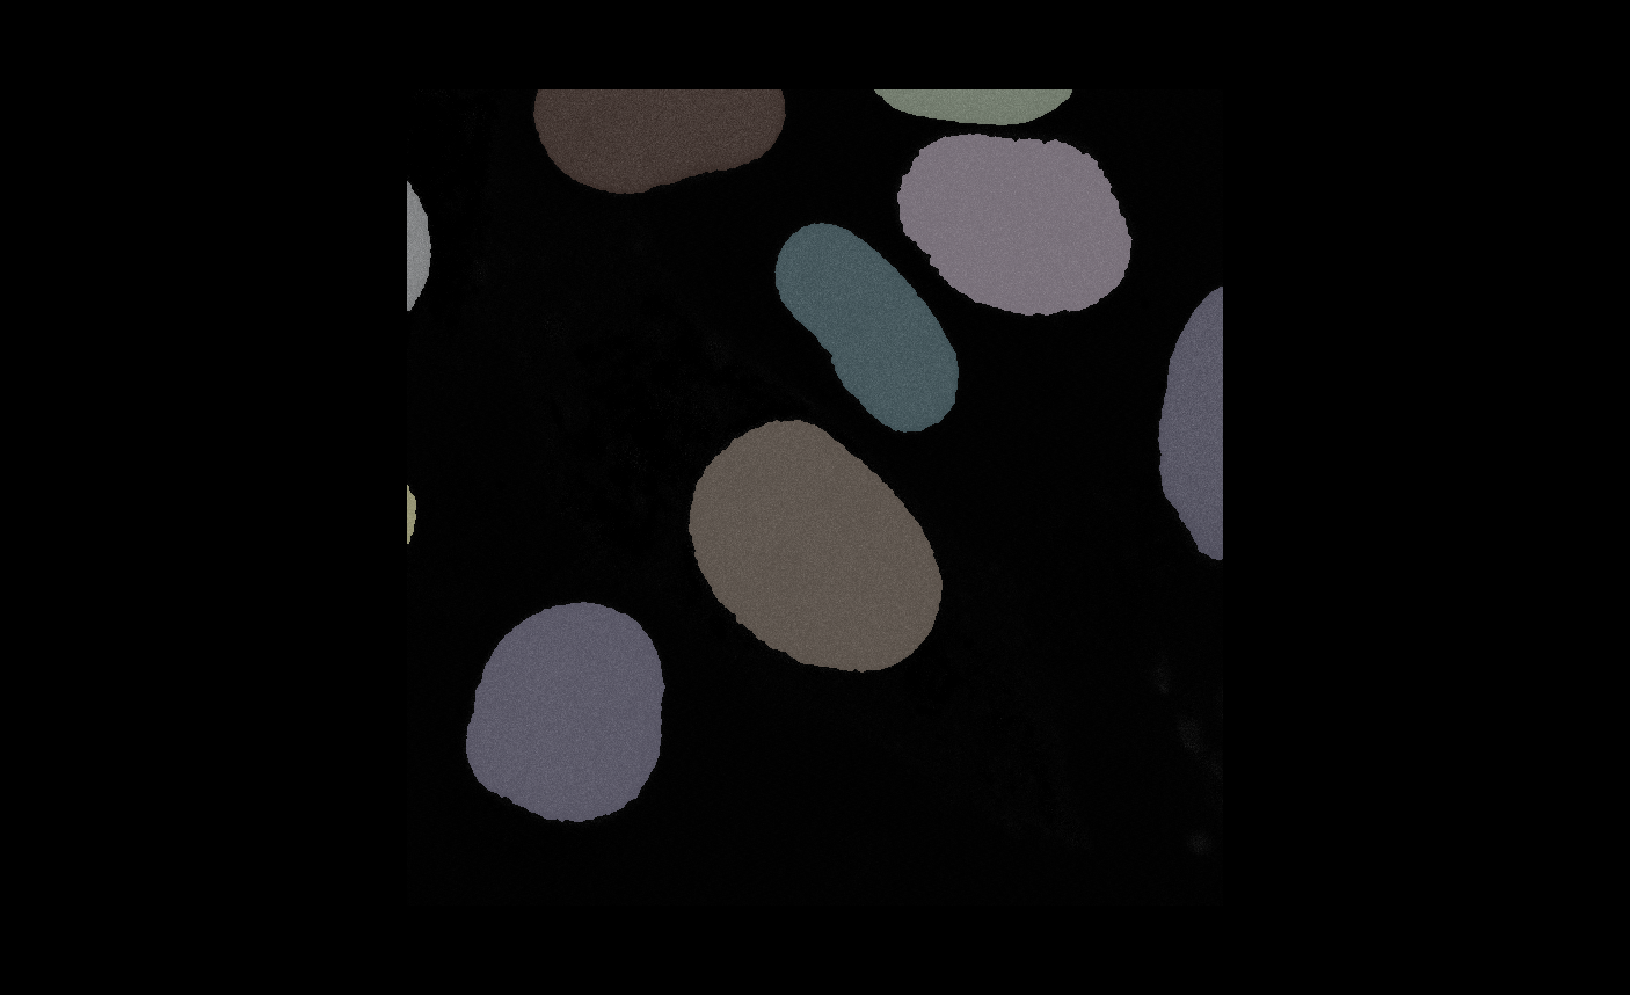

In [25]:
from napari.utils.notebook_display import nbscreenshot

nbscreenshot(viewer, canvas_only=True)

In [26]:
viewer.close()

-------------
## SUMMARY

The above explains the general procedure for segmenting all the nuclei in an image based on a fluorescent nuclei marker (single channel). 

### NEXT: INFER CELLMASK

proceed to [02_infer_cellmask.ipynb](./02_infer_cellmask.ipynb)
